In [ ]:
import torch
import matplotlib.pyplot as plt
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# Set random seed for reproducibility
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the device
model = sbm.PhaseNet(phases="PSN")
model.to(device)

# Load the data
data = sbd.OKLA(sampling_rate=100, force=True)
train, dev, test = data.train_dev_test()

# Set up data augmentation
phase_dict = {"p_arrival_sample": "P", "s_arrival_sample": "S"}
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

# Set up data loaders
batch_size = 1024
num_workers = 18
train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

# Training parameters
learning_rate = 1e-5
epochs = 40
patience = 3

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create learning rate scheduler
scheduler_step_size = 5
gamma = 1
#gamma = 0.1
scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=gamma)

# Define loss function
def loss_fn(y_pred, y_true, eps=1e-5):
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)
    h = h.mean()
    return -h

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    train_losses = []
    
    for batch_id, batch in enumerate(dataloader):
        pred = model(batch["X"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return train_losses

# Validation loop
def test_loop(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    test_loss = 0
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(device))
            test_loss += loss_fn(pred, batch["y"].to(device)).item()

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")
    return test_loss

# Main function
def main(train_loader, dev_loader, model, loss_fn, optimizer, epochs, device, learning_rate, batch_size, patience):
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
     
    for t in range(epochs):
        if early_stop:
            print("Early stopping")
            break
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_train_losses = train_loop(train_loader, model, loss_fn, optimizer, device)
        train_losses.extend(epoch_train_losses)
        
        test_loss = test_loop(dev_loader, model, loss_fn, device)
        test_losses.append(test_loss)
        
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True
        
        scheduler.step()
      
    plt.figure(figsize=(10, 5))
    train_loss_indices = np.linspace(0, len(train_losses)-1, num=len(train_losses), dtype=int)
    plt.plot(train_loss_indices, train_losses, label='Training Loss')
    
    test_loss_indices = np.linspace(0, len(train_losses)-1, num=len(test_losses), dtype=int)
    plt.plot(test_loss_indices, test_losses, label='Test Loss', marker='o')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.savefig("loss_curve.png")
    plt.show()
    
    torch.save(model.state_dict(), "final_model.pth")
    print("Final model saved as final_model.pth")

main(train_loader, dev_loader, model, loss_fn, optimizer, epochs, device, learning_rate, batch_size, patience)


Using device: cuda:1


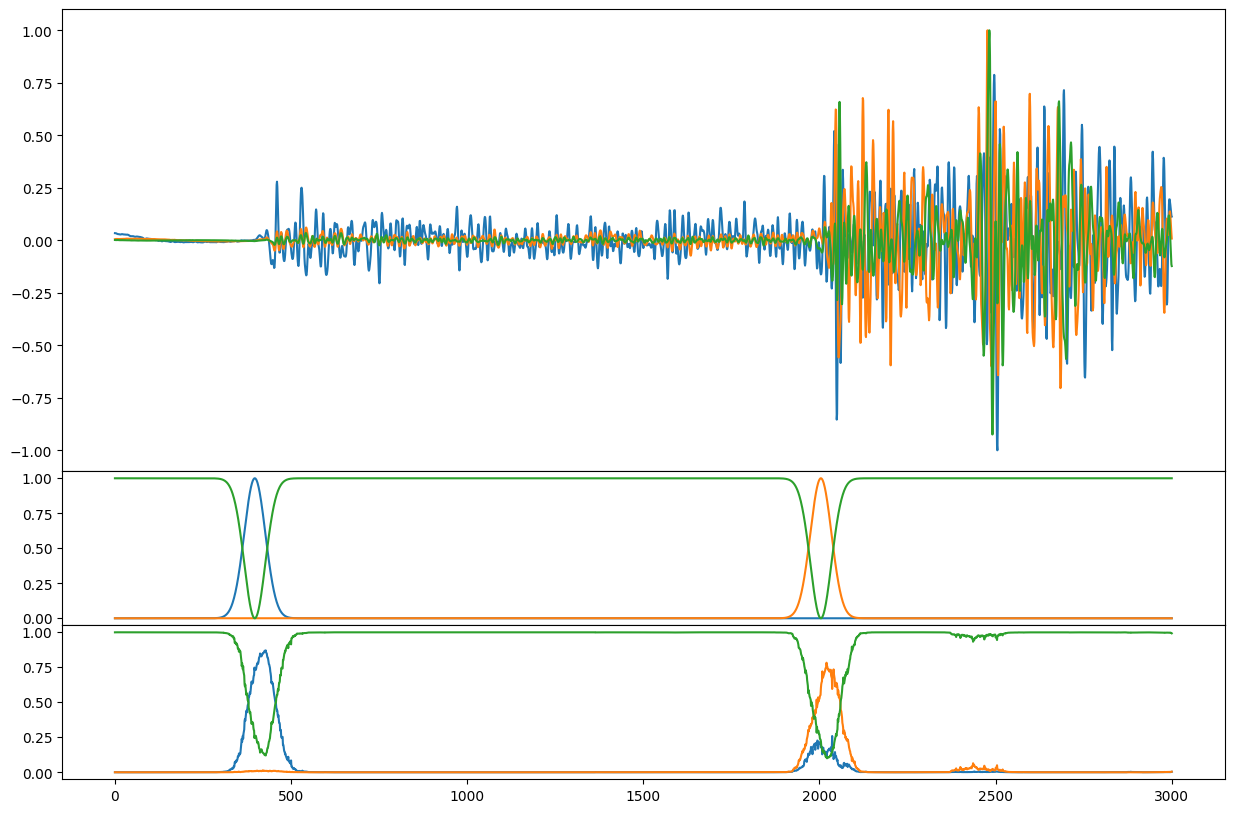

In [1]:
import torch
import matplotlib.pyplot as plt
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
import numpy as np

# Set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the device
model = sbm.PhaseNet(phases="PSN")
model.to(device)

# Load the data
data = sbd.OKLA(sampling_rate=100, force=True)
train, dev, test = data.train_dev_test()

# Set up data augmentation
phase_dict = {"p_arrival_sample": "P", "s_arrival_sample": "S"}
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

# Load the model
def load_model(model, model_filename, device):
    """
    Load the model from a file.
    Args:
        model: Model architecture to load the weights into.
        model_filename: Filename of the saved model.
        device: Device to load the model onto.
    Returns:
        Model with loaded weights.
    """
    model.load_state_dict(torch.load(model_filename, map_location=device))
    model.to(device)
    return model

# Load the final model
model_filename = "final_model.pth"
model = load_model(model, model_filename, device)

# Visualizing Predictions
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)
plt.show()


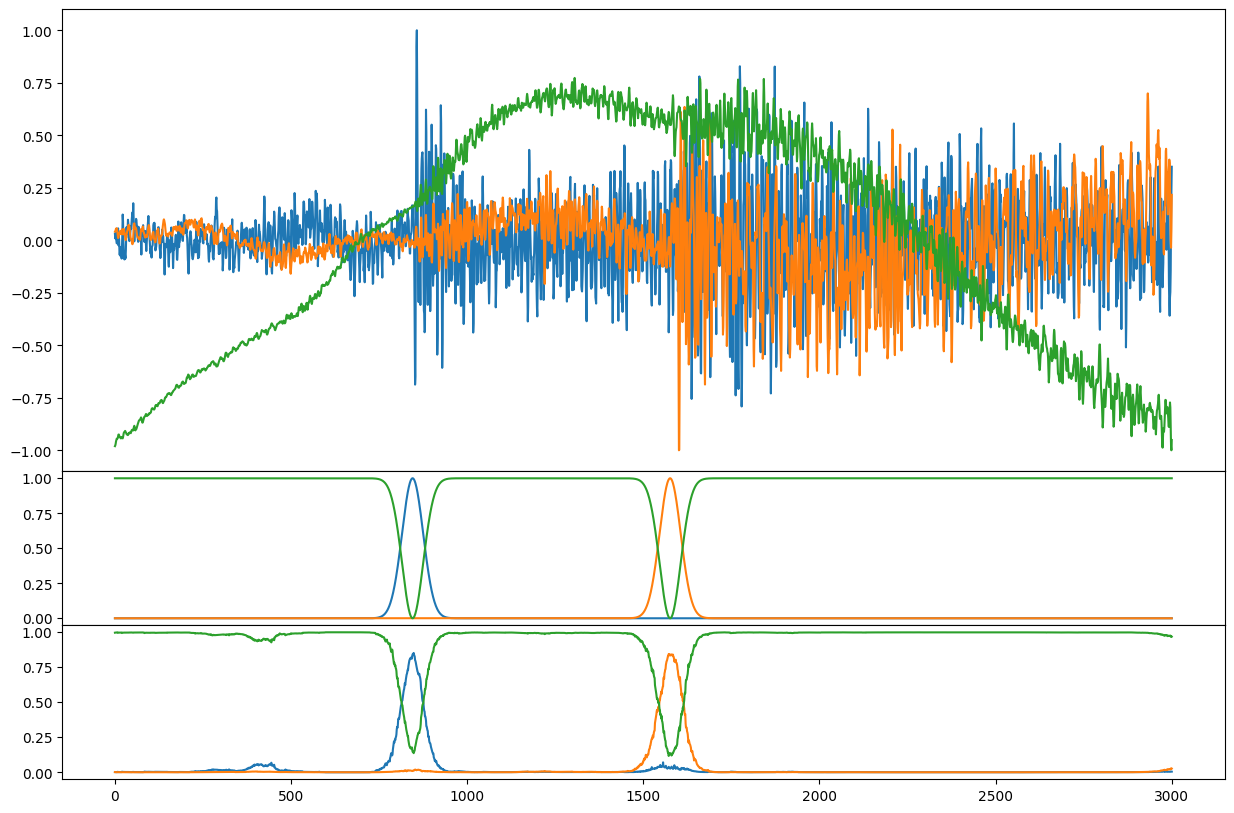

In [4]:
sample = dev_generator[np.random.randint(len(dev_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)
plt.show()

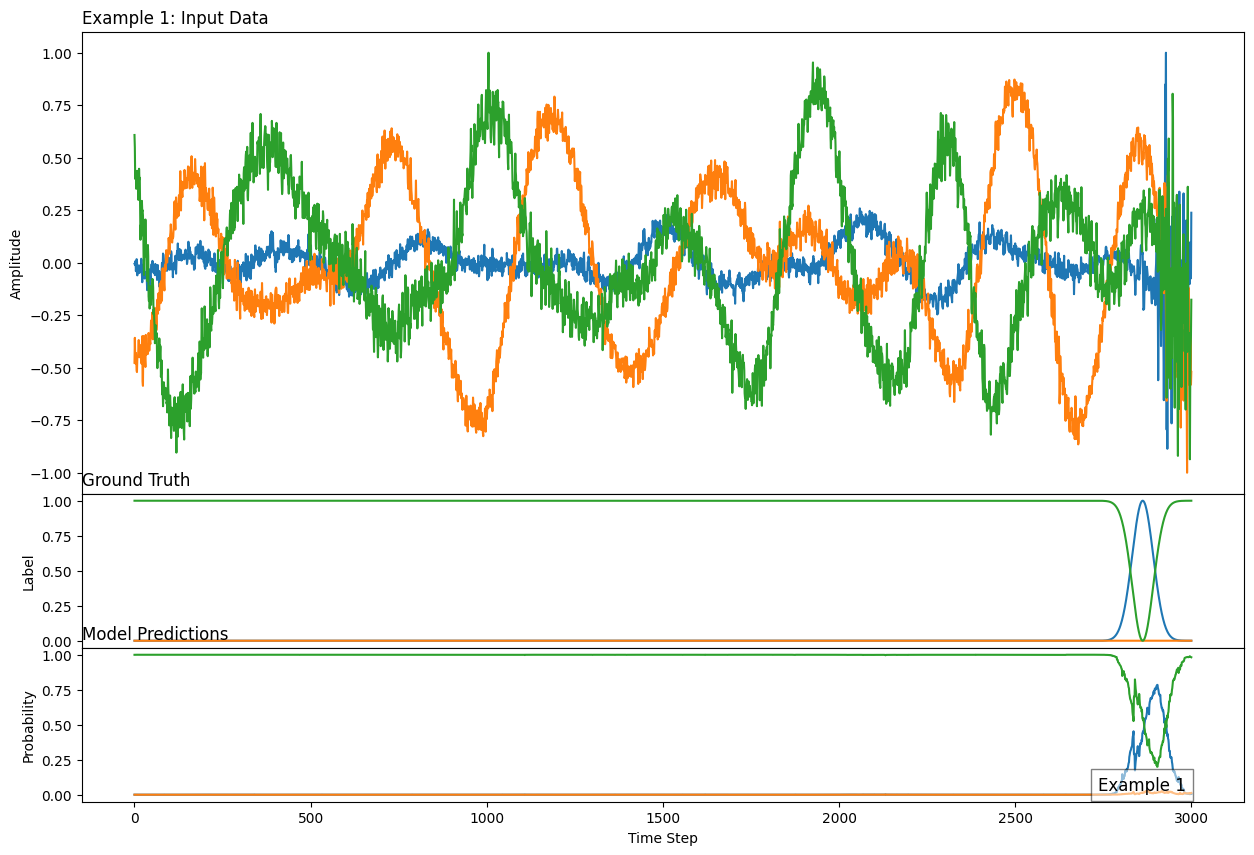

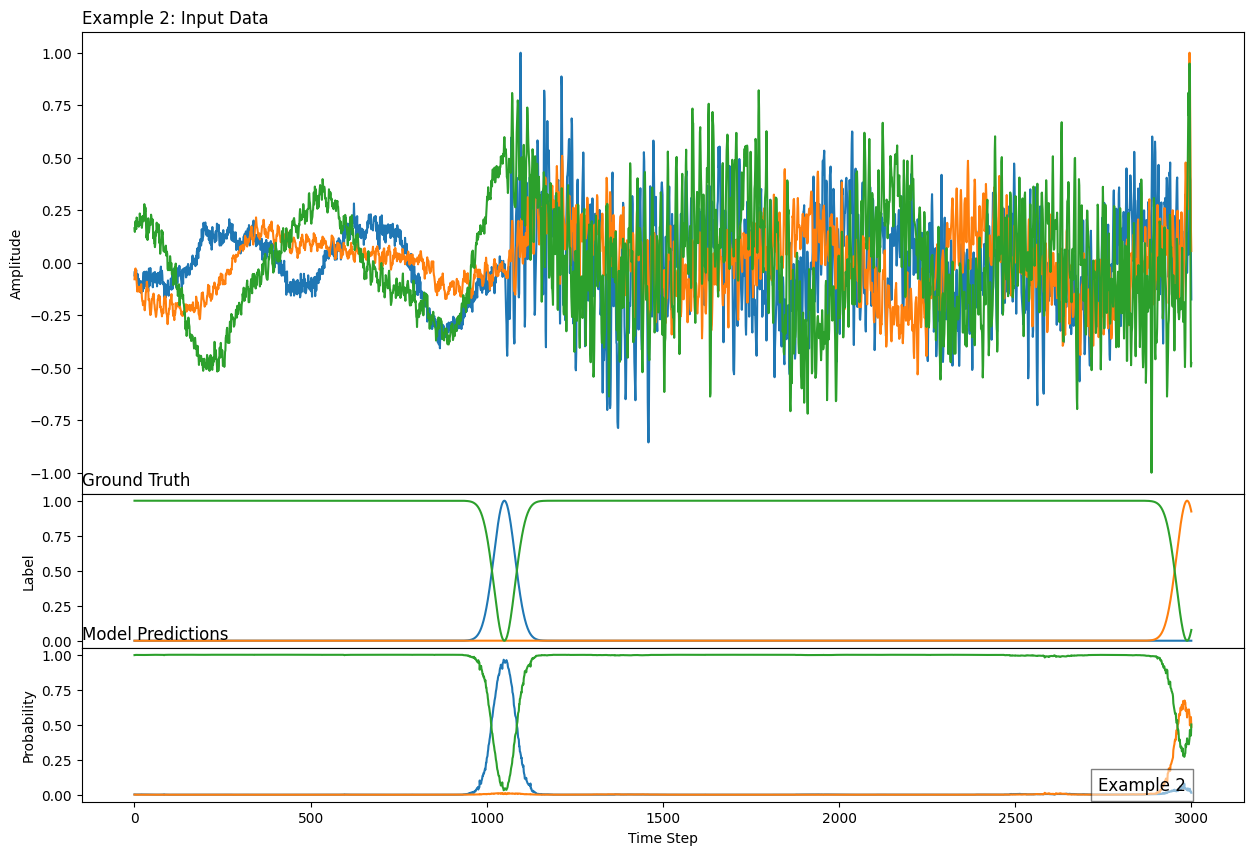

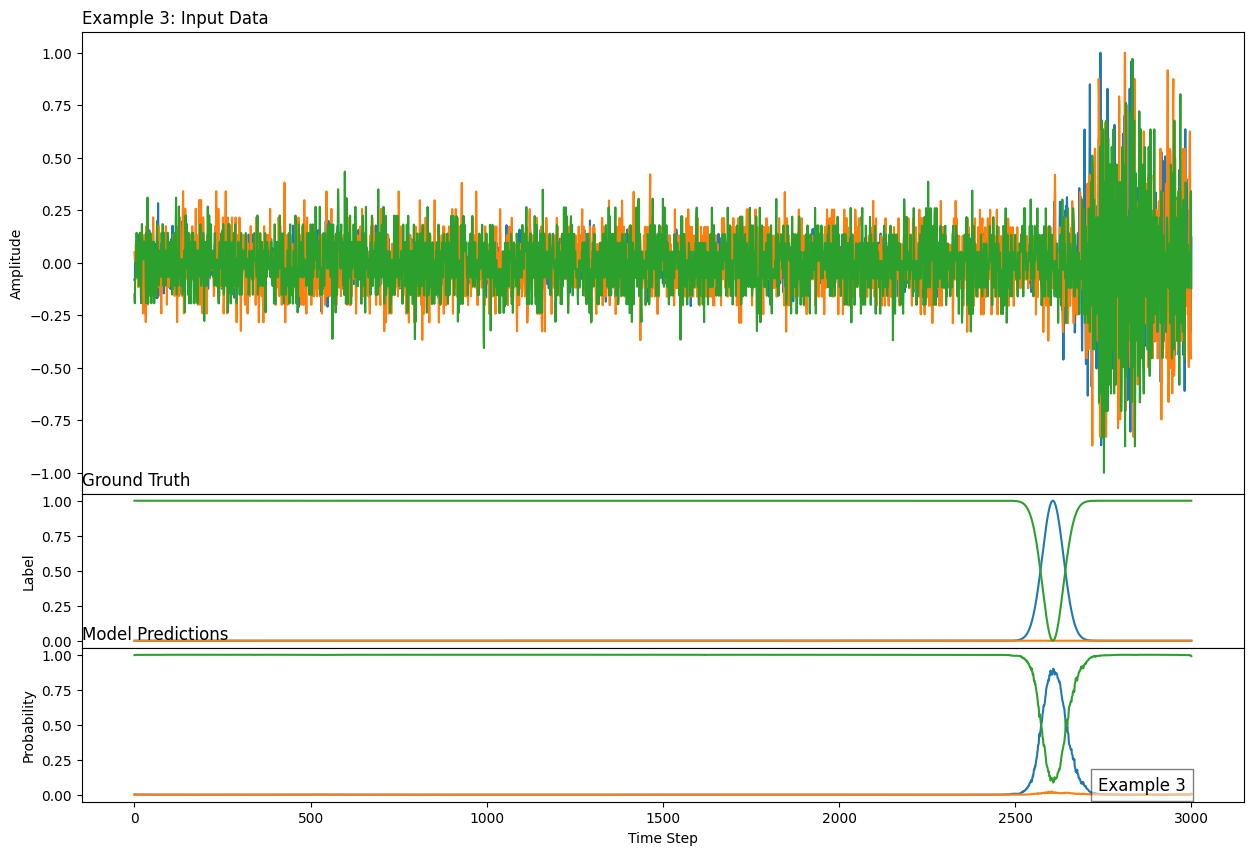

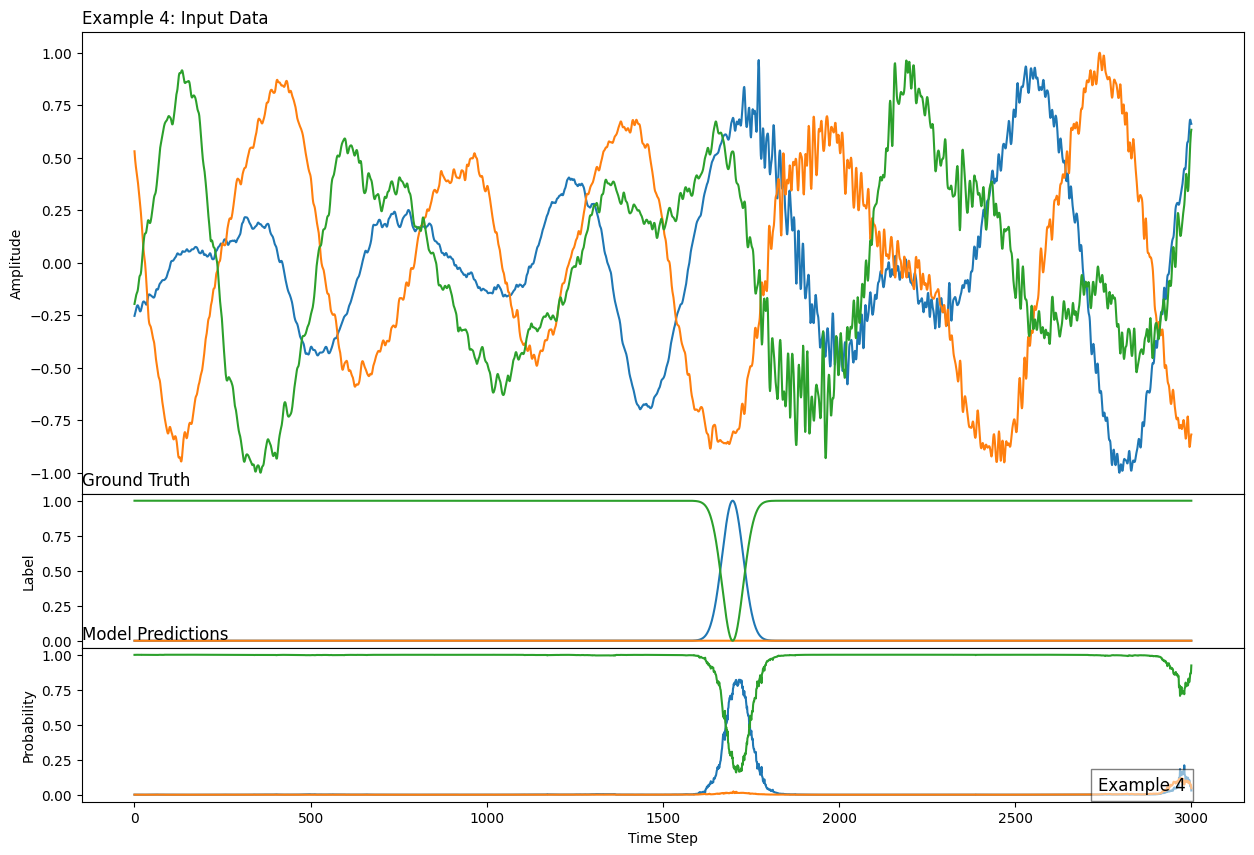

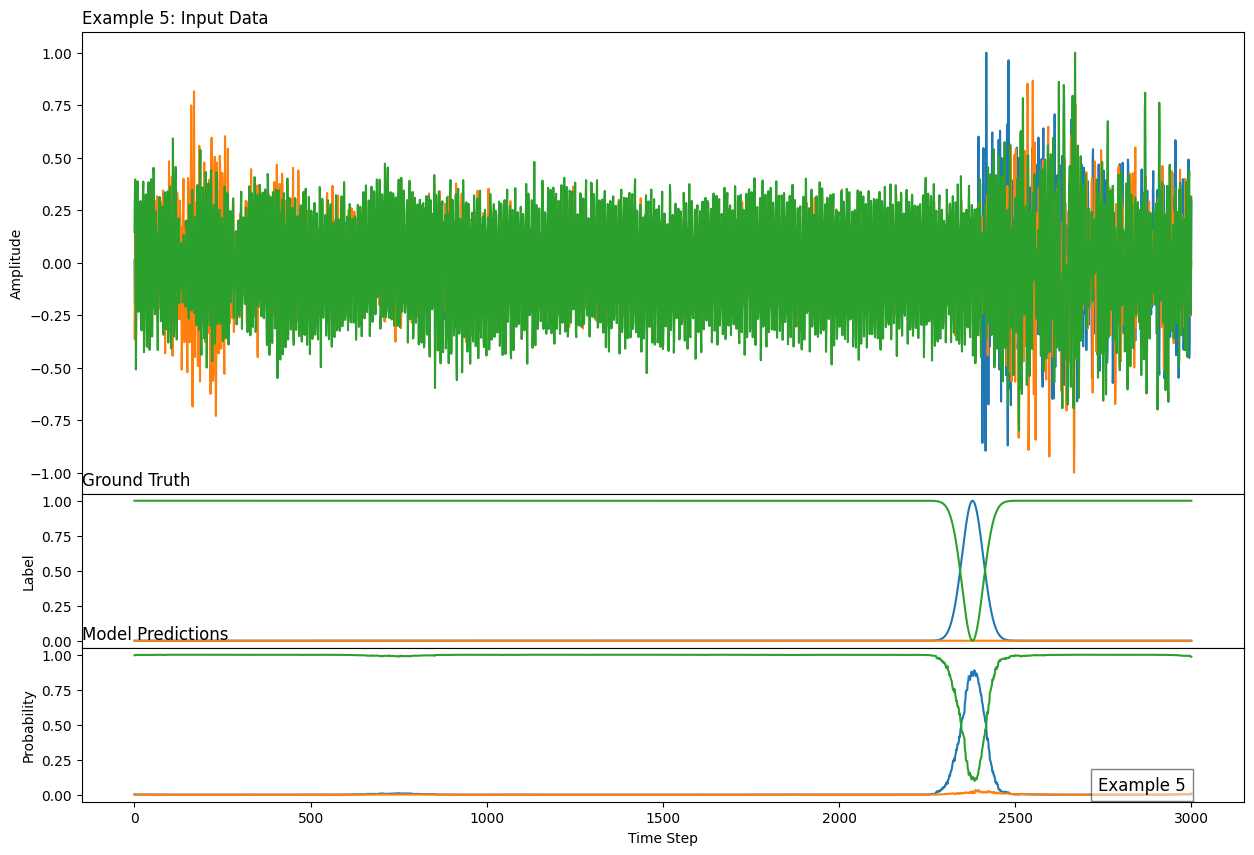

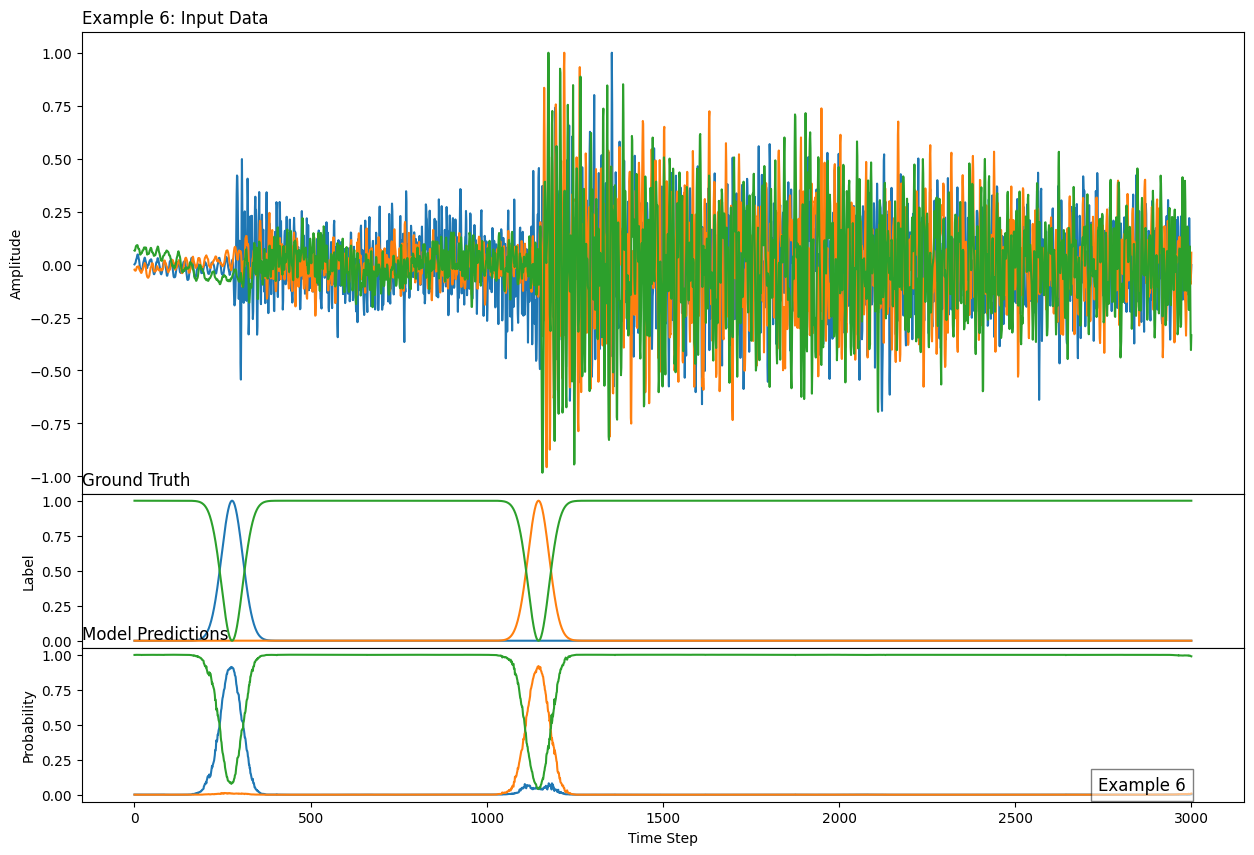

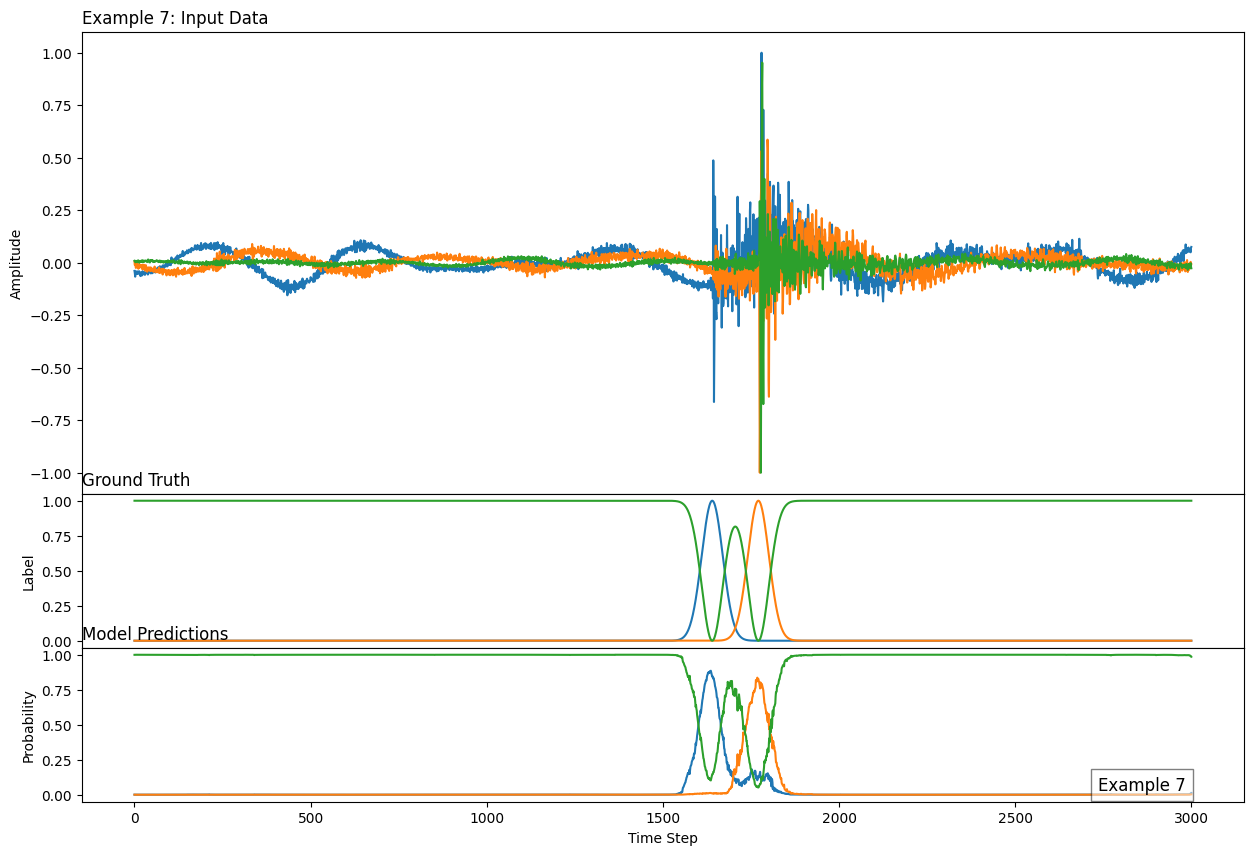

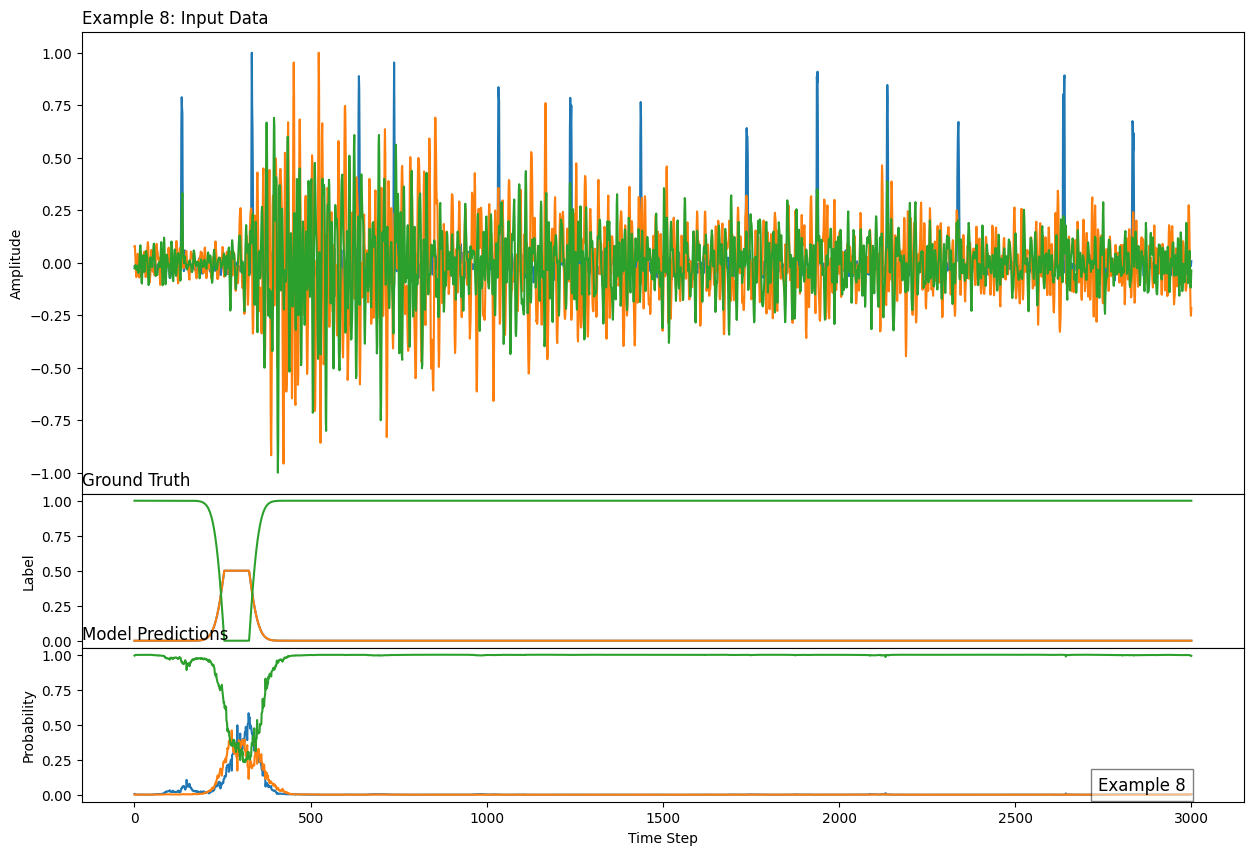

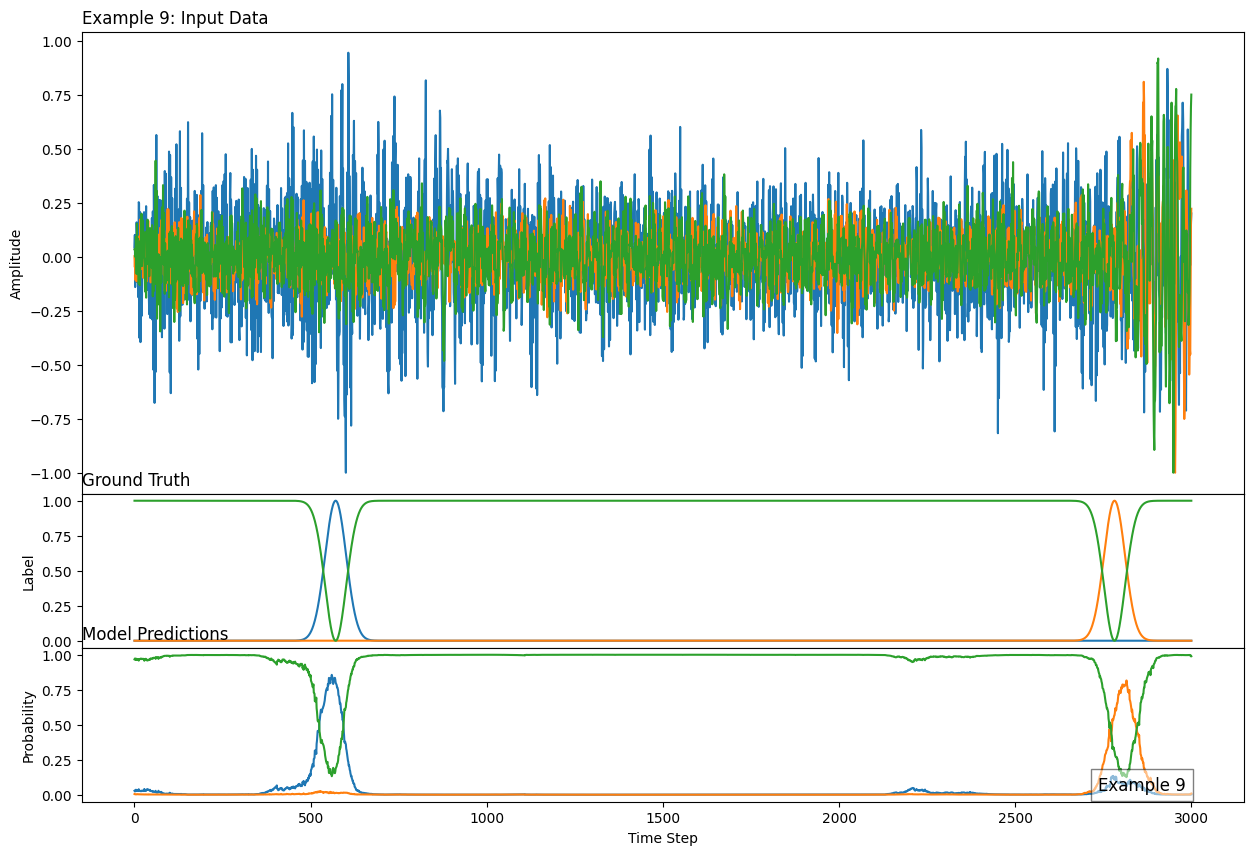

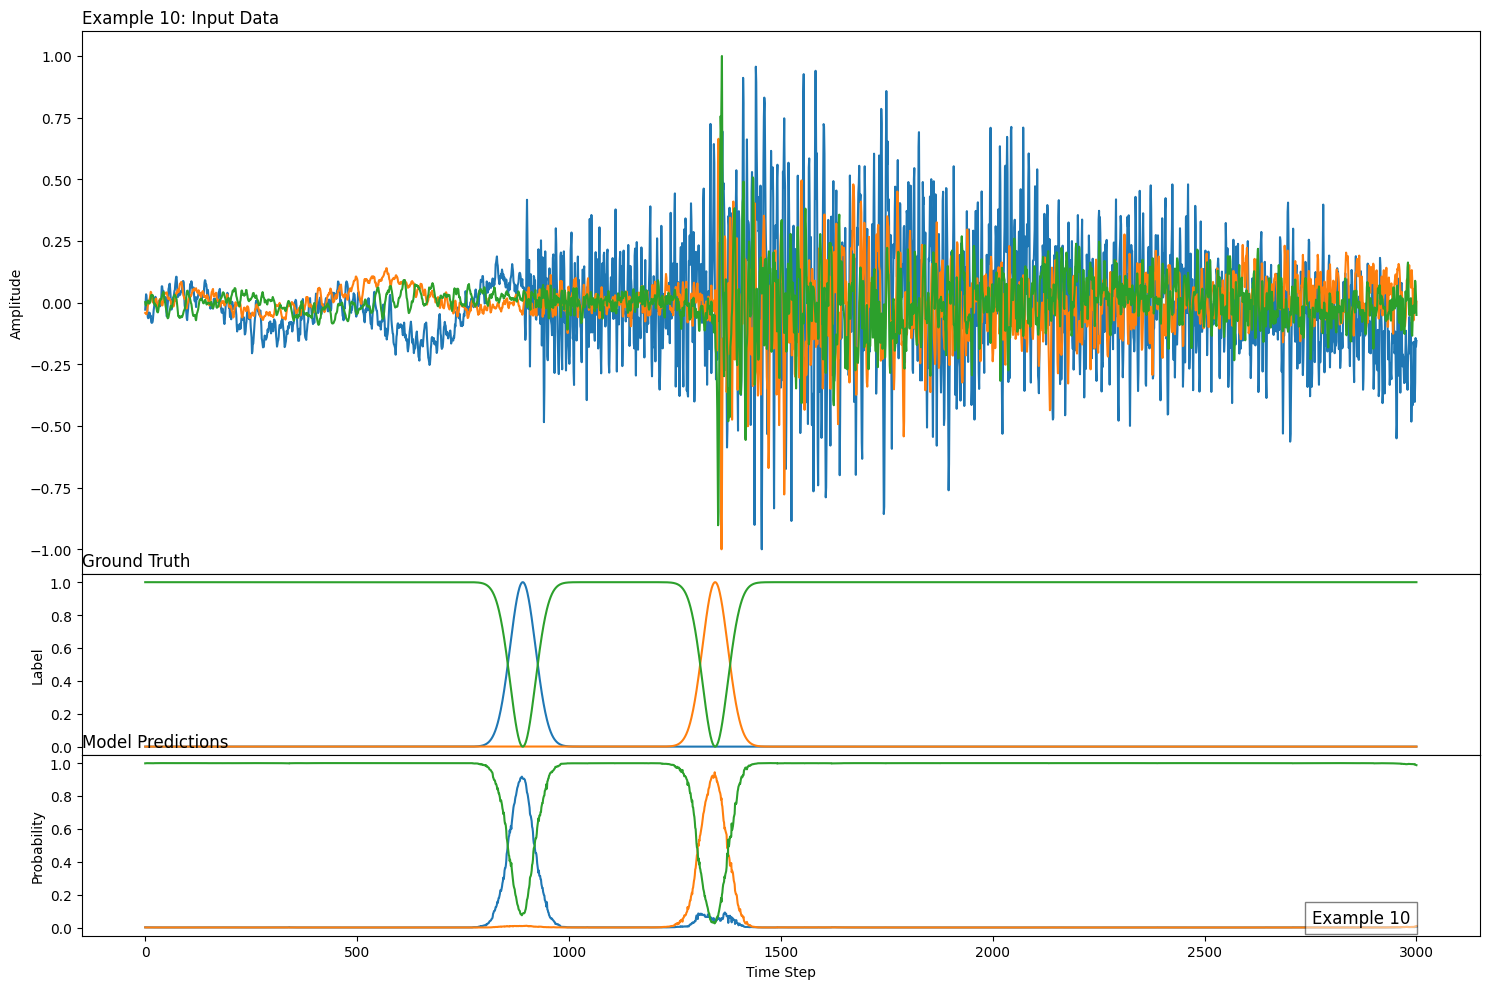

In [5]:
# Plotting 10 examples
num_examples = 10

for i in range(num_examples):
    sample = dev_generator[np.random.randint(len(dev_generator))]

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
    axs[0].plot(sample["X"].T)
    axs[1].plot(sample["y"].T)

    # Evaluate model predictions
    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()

    axs[2].plot(pred.T)

    # Adjust subplot titles and labels
    axs[0].set_title(f"Example {i + 1}: Input Data", loc='left')  # Set title to lower left
    axs[0].set_ylabel('Amplitude')
    axs[1].set_title("Ground Truth", loc='left')  # Set title to lower left
    axs[1].set_ylabel('Label')
    axs[2].set_title("Model Predictions", loc='left')  # Set title to lower left
    axs[2].set_xlabel('Time Step')
    axs[2].set_ylabel('Probability')

    # Add title at the lower right corner of the prediction panel
    axs[2].text(0.95, 0.05, f"Example {i + 1}", verticalalignment='bottom', horizontalalignment='right', transform=axs[2].transAxes, fontsize=12, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})

plt.tight_layout()
plt.show()

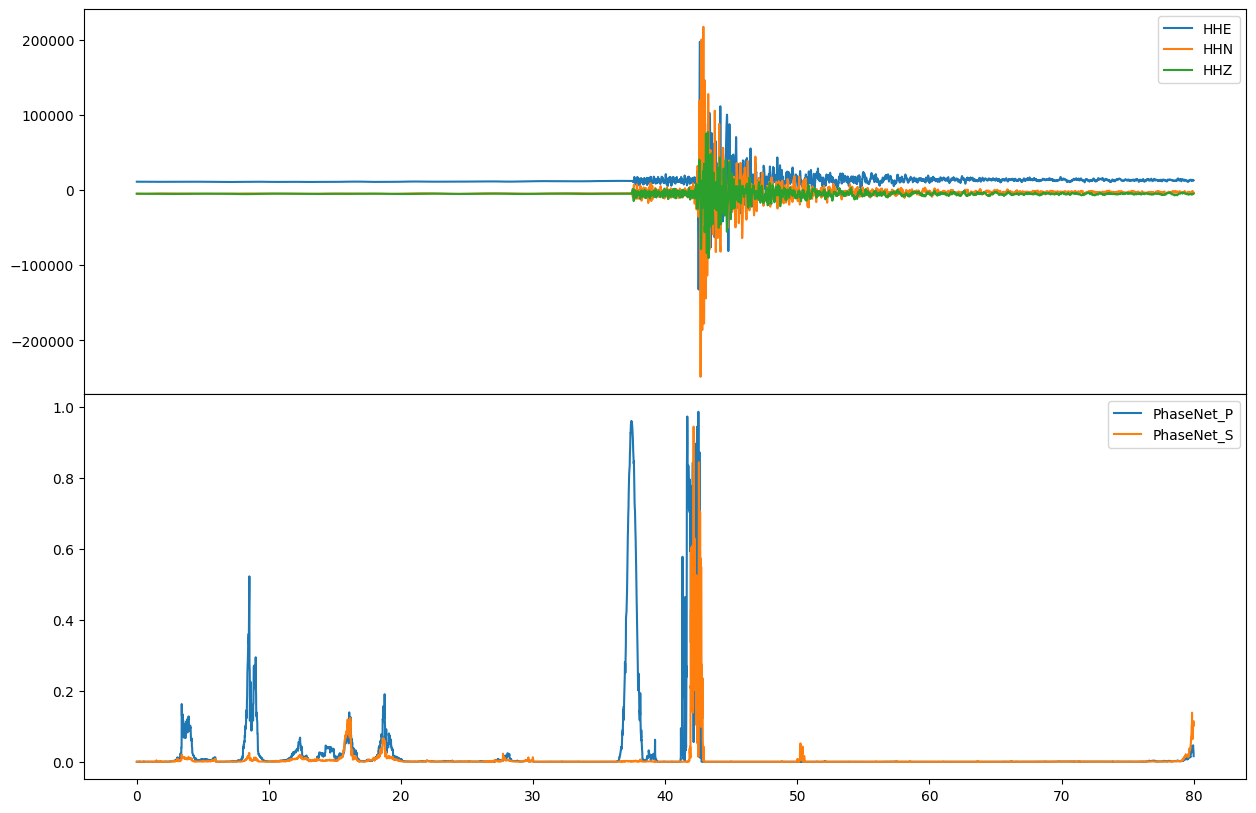

In [6]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pathlib import Path

client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)

annotations = model.annotate(stream)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()
plt.show()